In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show Code"></form>''')

In [2]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set(style ='white',font_scale=1.25)

%matplotlib inline

In [3]:
with open('../data/01-House-Price/processed_data.pkl','rb') as file:
    FEATURES, ordinal_map, interactions, train, y = pickle.load(file)

# **Train-test split**

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=42)

print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1005, 415)
X_test : (431, 415)
y_train : (1005,)
y_test : (431,)


# **Feature Standardizing**
- Perform standardization on all features except those one hot encoded.

In [5]:
feat_to_norm = FEATURES['cont'] + list(ordinal_map.keys()) + [inter for inter in interactions if len(inter.split('_')) < 3]

In [6]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_train[feat_to_norm])

X_num_train_norm = pd.DataFrame(ss.transform(X_train[feat_to_norm]),columns=feat_to_norm,index=X_train.index)
X_cat_train = X_train[[col for col in X_train.columns if col not in feat_to_norm]]
X_train_preproc = pd.concat([X_num_train_norm,X_cat_train],axis=1)

X_num_test_norm = pd.DataFrame(ss.transform(X_test[feat_to_norm]),columns=feat_to_norm,index=X_test.index)
X_cat_test = X_test[[col for col in X_test.columns if col not in feat_to_norm]]
X_test_preproc = pd.concat([X_num_test_norm,X_cat_test],axis=1)


In [7]:
from collections import namedtuple

models = namedtuple('models',['name','params',
                              'cv5_mean_accuracy_train','cv5_std_accuracy_train',
                              'cv5_mean_accuracy_test','cv5_std_accuracy_test'])
model_list = []

# **Linear Regression**

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import cross_val_score

In [9]:
def cv_rmse(mod,X,y,cv=5):
    scores = cross_val_score(mod,X,y,scoring="neg_mean_squared_error",cv=cv)
    return np.sqrt(-scores)

In [10]:
lr = LinearRegression()
lr.fit(X_train_preproc,y_train)


y_train_pred = lr.predict(X_train_preproc)
y_test_pred = lr.predict(X_test_preproc)

print('Train R-sq:',r2_score(y_train,y_train_pred))
print('Test R-sq:',r2_score(y_test,y_test_pred))

Train R-sq: 0.9626927825245313
Test R-sq: 0.6641933327313119


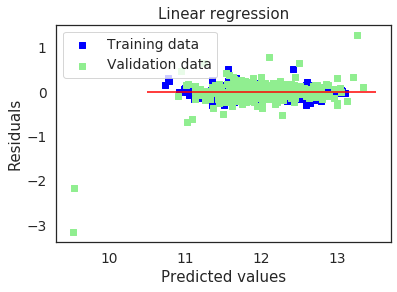

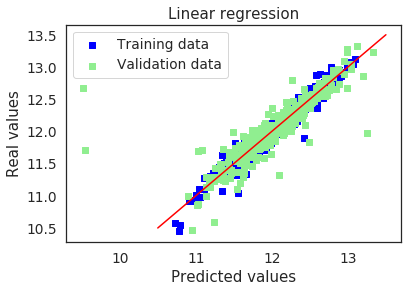

In [11]:
# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")

In [12]:
cv5_accuracy_train =  cv_rmse(lr, X_train_preproc, y_train, cv=5)
cv5_accuracy_test =  cv_rmse(lr, X_test_preproc, y_test, cv=5)

print('CV5 train accuracies:',cv5_accuracy_train)
print('-'*75)
print('CV5 test accuracies:', cv5_accuracy_test)

model_list.append(models(name='LR',params=lr.get_params(),
                         cv5_mean_accuracy_train = np.mean(cv5_accuracy_train),
                         cv5_std_accuracy_train=np.std(cv5_accuracy_train),
                         cv5_mean_accuracy_test=np.mean(cv5_accuracy_test),
                         cv5_std_accuracy_test=np.std(cv5_accuracy_test)))

CV5 train accuracies: [ 2.65643053  5.40624294  0.21713225  0.19368233 17.11022293]
---------------------------------------------------------------------------
CV5 test accuracies: [ 1.30022487  0.85006071  1.38351961  4.20493797 30.61361425]


The model fits the train set well and provides reasonble train accuracy. However, it does not gneralize to the test set.
The test accuracy is very low which is also evident from the cross validation scores. This is a case of overfitting.

There are ways to mitigate overfitting and that is by using regularization.

# **Linear Regression with Ridge regularization (L2 penatly)**

In [13]:
from sklearn.linear_model import RidgeCV, Ridge

ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train_preproc, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Best alpha : 10.0


In [14]:
ridge = Ridge(alpha=1)
ridge.fit(X_train_preproc, y_train)
y_pred = ridge.predict(X_test_preproc)

print('Test accuracies:')
print('-'*50)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

Test accuracies:
--------------------------------------------------
R-sq: 0.9134907589414636
MSE: 0.01499452094549957
RMSE: 0.1224521169498493
--------------------------------------------------
R-sq orig price: 0.9239306386255861
MSE orig price: 521485986.4619516
RMSE orig price: 22836.067666346404


In [15]:
ridge = Ridge(alpha=10)
ridge.fit(X_train_preproc, y_train)
y_pred = ridge.predict(X_test_preproc)

print('Test accuracies:')
print('-'*50)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

Test accuracies:
--------------------------------------------------
R-sq: 0.9191345421047147
MSE: 0.014016292217357512
RMSE: 0.11839042282785171
--------------------------------------------------
R-sq orig price: 0.9299098063978524
MSE orig price: 480496392.9172566
RMSE orig price: 21920.227939445715


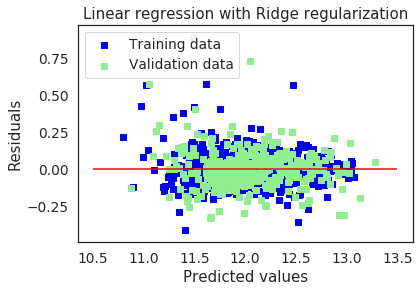

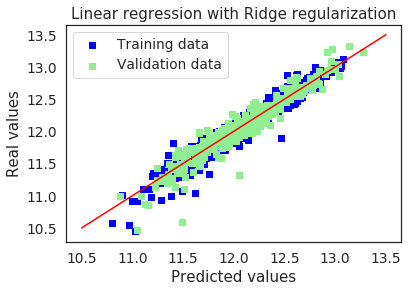

Ridge picked 410 features and eliminated the other 5 features


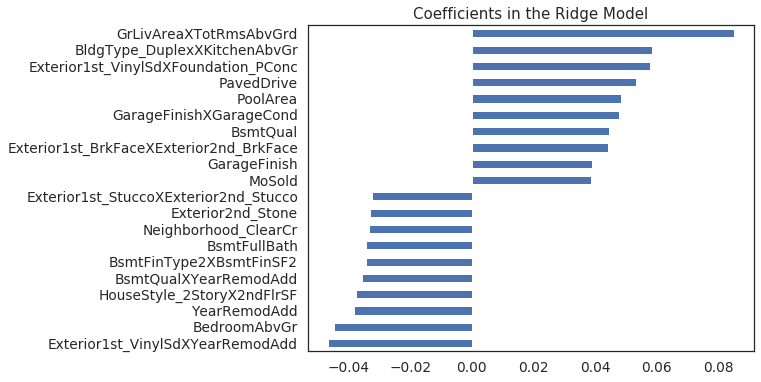

In [16]:
y_train_rdg = ridge.predict(X_train_preproc)
y_test_rdg = ridge.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the Ridge Model");

In [17]:
cv5_accuracy_train =  cv_rmse(ridge, X_train_preproc, y_train, cv=5)
cv5_accuracy_test =  cv_rmse(ridge, X_test_preproc, y_test, cv=5)

print('CV5 train R-sq:',cv5_accuracy_train)
print('-'*75)
print('CV5 test R-sq:', cv5_accuracy_test)

model_list.append(models(name='ridge',params=ridge.get_params(),
                         cv5_mean_accuracy_train = np.mean(cv5_accuracy_train),
                         cv5_std_accuracy_train=np.std(cv5_accuracy_train),
                         cv5_mean_accuracy_test=np.mean(cv5_accuracy_test),
                         cv5_std_accuracy_test=np.std(cv5_accuracy_test)))

CV5 train R-sq: [0.12124443 0.10077859 0.10518827 0.12760233 0.10929833]
---------------------------------------------------------------------------
CV5 test R-sq: [0.12732013 0.15217383 0.12206122 0.14157187 0.12674363]


# **Linear Regression with Lasso regularization (L1 penalty)**

In [18]:
from sklearn.linear_model import LassoCV, Lasso

lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train_preproc, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

Best alpha : 0.0006


In [19]:
lasso = Lasso(alpha=1)
lasso.fit(X_train_preproc, y_train)
y_pred = lasso.predict(X_test_preproc)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

R-sq: -0.0003365656948961515
MSE: 0.17338688217957873
RMSE: 0.4163975050112317
--------------------------------------------------
R-sq orig price: -0.0404144830029356
MSE orig price: 7132458629.797031
RMSE orig price: 84453.88463414239


In [20]:
lasso = Lasso(alpha=0.0006)
lasso.fit(X_train_preproc, y_train)
y_pred = lasso.predict(X_test_preproc)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

R-sq: 0.923255426277555
MSE: 0.01330202535652792
RMSE: 0.11533440664662008
--------------------------------------------------
R-sq orig price: 0.9367245954942134
MSE orig price: 433778279.9972064
RMSE orig price: 20827.344525820048


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4990125487965731, tolerance: 0.014647108757701699
  positive)


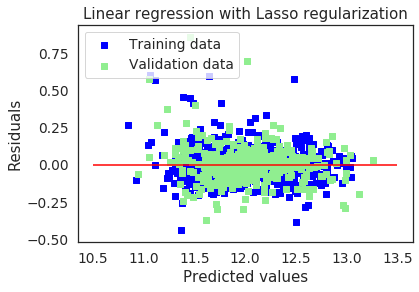

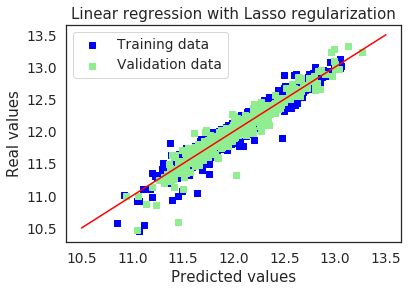

Lasso picked 140 features and eliminated the other 275 features


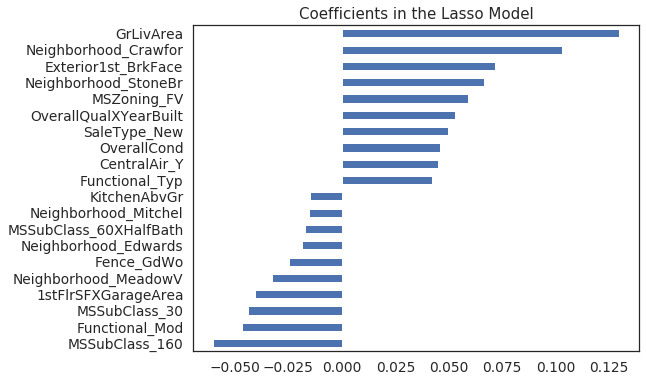

In [21]:
y_train_las = lasso.predict(X_train_preproc)
y_test_las = lasso.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train_preproc.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the Lasso Model");

In [22]:
cv5_accuracy_train =  cv_rmse(lasso, X_train_preproc, y_train, cv=5)
cv5_accuracy_test = cv_rmse(lasso, X_test_preproc, y_test, cv=5)

print('CV5 train R-sq:',cv5_accuracy_train)
print('-'*75)
print('CV5 test R-sq:', cv5_accuracy_test)

model_list.append(models(name='lasso',params=lasso.get_params(),
                         cv5_mean_accuracy_train = np.mean(cv5_accuracy_train),
                         cv5_std_accuracy_train=np.std(cv5_accuracy_train),
                         cv5_mean_accuracy_test=np.mean(cv5_accuracy_test),
                         cv5_std_accuracy_test=np.std(cv5_accuracy_test)))

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18711554586671042, tolerance: 0.011686853311948011
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16886937592314677, tolerance: 0.011864433867997948
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10412106453767755, tolerance: 0.011840654302834387
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might w

CV5 train R-sq: [0.1209322  0.10352847 0.10763107 0.12531223 0.10542878]
---------------------------------------------------------------------------
CV5 test R-sq: [0.13989674 0.1526601  0.12440411 0.14402284 0.13368437]


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.059452063129235455, tolerance: 0.005767466206725459
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04901739198373467, tolerance: 0.005872537820347414
  positive)


# **Linear Regression with ElasticNet Regularization (L1 and L2 penalty)**

In [23]:
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import RandomizedSearchCV

Looks like model prefers be apply only L2 penatly

In [24]:
enet = ElasticNet(alpha=1,l1_ratio=0.5)
enet.fit(X_train_preproc,y_train)
y_pred = enet.predict(X_test_preproc)

print('R-sq:', r2_score(y_test,y_pred))
print('MSE:', mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:', r2_score(y_test_exp,y_pred_exp))
print('MSE:', mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:', np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: -0.0003365656948961515
MSE: 0.17338688217957873
RMSE: 0.4163975050112317
--------------------------------------------------
R-sq: -0.0404144830029356
MSE: 7132458629.797031
RMSE: 84453.88463414239


In [25]:
enet = ElasticNet(l1_ratio=0,alpha=0.03)
enet.fit(X_train_preproc,y_train)
y_pred = enet.predict(X_test_preproc)

print('R-sq:', r2_score(y_test,y_pred))
print('MSE:', mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:', r2_score(y_test_exp,y_pred_exp))
print('MSE:', mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:', np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.9194982168247705
MSE: 0.013953257007008875
RMSE: 0.11812390531560017
--------------------------------------------------
R-sq: 0.9320006882307498
MSE: 466162559.22254294
RMSE: 21590.798021901435


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.147913901719836, tolerance: 0.014647108757701699
  positive)


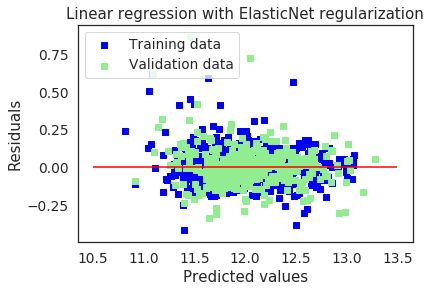

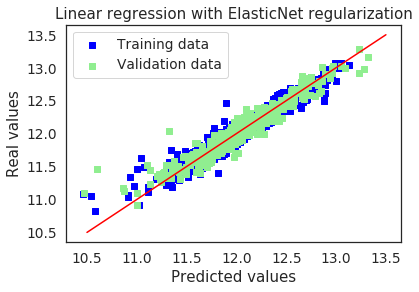

ElasticNet picked 410 features and eliminated the other 5 features


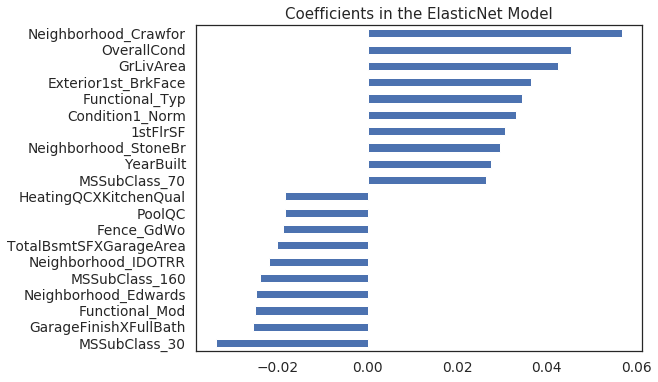

In [26]:
y_train_ela = enet.predict(X_train_preproc)
y_test_ela = enet.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(enet.coef_, index = X_train_preproc.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the ElasticNet Model");

In [27]:
cv5_accuracy_train =  cv_rmse(enet, X_train_preproc, y_train, cv=5)
cv5_accuracy_test =  cv_rmse(enet, X_test_preproc, y_test, cv=5)

print('CV5 train R-sq:',cv5_accuracy_train)
print('-'*75)
print('CV5 test R-sq:', cv5_accuracy_test)

model_list.append(models(name='ElasticNet',params=enet.get_params(),
                         cv5_mean_accuracy_train = np.mean(cv5_accuracy_train),
                         cv5_std_accuracy_train=np.std(cv5_accuracy_train),
                         cv5_mean_accuracy_test=np.mean(cv5_accuracy_test),
                         cv5_std_accuracy_test=np.std(cv5_accuracy_test)))

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7531995533302536, tolerance: 0.011686853311948011
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.137631434519589, tolerance: 0.011864433867997948
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.15536284509357, tolerance: 0.011840654302834387
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to

CV5 train R-sq: [0.12063508 0.10091357 0.10680455 0.1268246  0.11138823]
---------------------------------------------------------------------------
CV5 test R-sq: [0.12796367 0.15249283 0.12209459 0.14239334 0.12757976]


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5617135553572636, tolerance: 0.005872537820347414
  positive)


# **Support Vector Machine Regression**

In [28]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [29]:
svm = SVR(C=0.1, cache_size=200, coef0=1, degree=3, epsilon=0.1,
          gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
          tol=0.001, verbose=False)
svm.fit(X_train_preproc,y_train)
y_pred = svm.predict(X_test_preproc)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.9069758438875548
MSE: 0.016123741697394573
RMSE: 0.12697929633367233
--------------------------------------------------
R-sq: 0.9171559395060123
MSE: 567929266.5095507
RMSE: 23831.26657375874


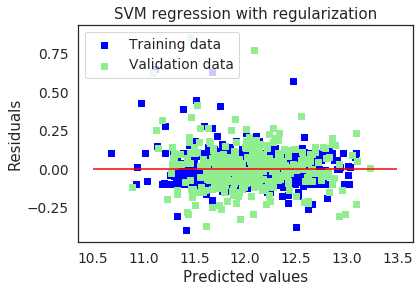

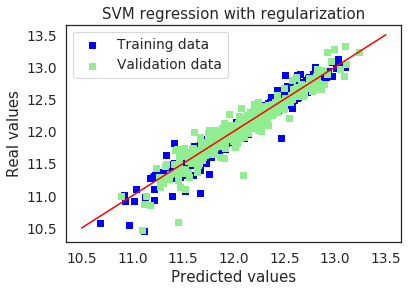

SVR picked up 397 features and eliminated 18 features


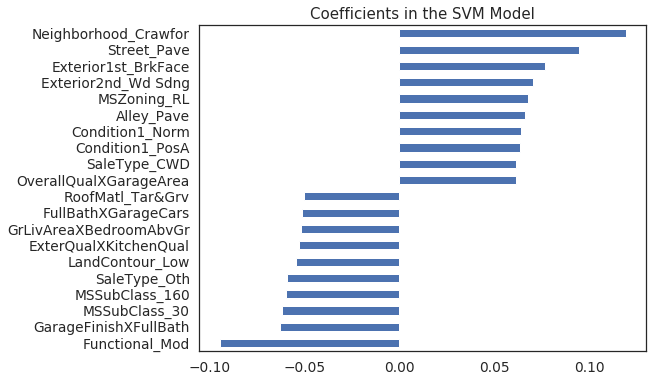

In [30]:
y_train_svm = svm.predict(X_train_preproc)
y_test_svm = svm.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_svm, y_train_svm - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_svm, y_test_svm - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("SVM regression with regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_svm, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_svm, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("SVM regression with regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(np.squeeze(svm.coef_) , index = X_train_preproc.columns)
print("SVR picked up " + str(sum(coefs != 0)) + " features and eliminated " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the SVM Model");

In [31]:
cv5_accuracy_train =  cv_rmse(svm, X_train_preproc, y_train, cv=5)
cv5_accuracy_test = cv_rmse(svm, X_test_preproc, y_test, cv=5)

print('CV5 train R-sq:',cv5_accuracy_train)
print('-'*75)
print('CV5 test R-sq:', cv5_accuracy_test)

model_list.append(models(name='svm',params=svm.get_params(),
                         cv5_mean_accuracy_train = np.mean(cv5_accuracy_train),
                         cv5_std_accuracy_train=np.std(cv5_accuracy_train),
                         cv5_mean_accuracy_test=np.mean(cv5_accuracy_test),
                         cv5_std_accuracy_test=np.std(cv5_accuracy_test)))

CV5 train R-sq: [0.13153525 0.11389571 0.11122262 0.14476186 0.10928718]
---------------------------------------------------------------------------
CV5 test R-sq: [0.14125356 0.16625767 0.13789202 0.16249601 0.14190583]


# **Random Forest**

In [33]:
from sklearn.ensemble import RandomForestRegressor

In [32]:
%%writefile random_forest.py

#!/usr/bin/env python
#SBATCH -t 5-30:30:30
#SBATCH --cores-per-socket=4
#SBATCH --sockets-per-node=2
#SBATCH --nodes=2-4
#SBATCH --mem=24000
#SBATCH -J rf
#SBATCH -o rf.out


import pandas as pd
import numpy as np
import pickle

with open('processed_data.pkl','rb') as file:
    FEATURES, ordinal_map, interactions, train, y = pickle.load(file)


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=42)

print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators':[50,100,150,200,250,300,350,400],
    'max_depth':[2,5,10,15,20,25,50,75,100],
    'min_samples_split':[4,8,10,15,20,25,30],
    'min_samples_leaf':[1,3,6,8,10,12,15],
}

rf_cv = GridSearchCV(RandomForestRegressor(),param_grid=param_grid,n_jobs=-1,cv=10)
rf_cv.fit(X_train,y_train)

with open('rf_mod.pkl','wb') as out:
    pickle.dump(rf_cv,out)

Overwriting random_forest.py


In [34]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8938840901529432
MSE: 0.01839291633336352
RMSE: 0.1356204864073401
--------------------------------------------------
R-sq: 0.898782603801
MSE: 693885852.9933654
RMSE: 26341.713174988552


In [35]:
feature_importance = pd.DataFrame(np.round(rf.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace =True)

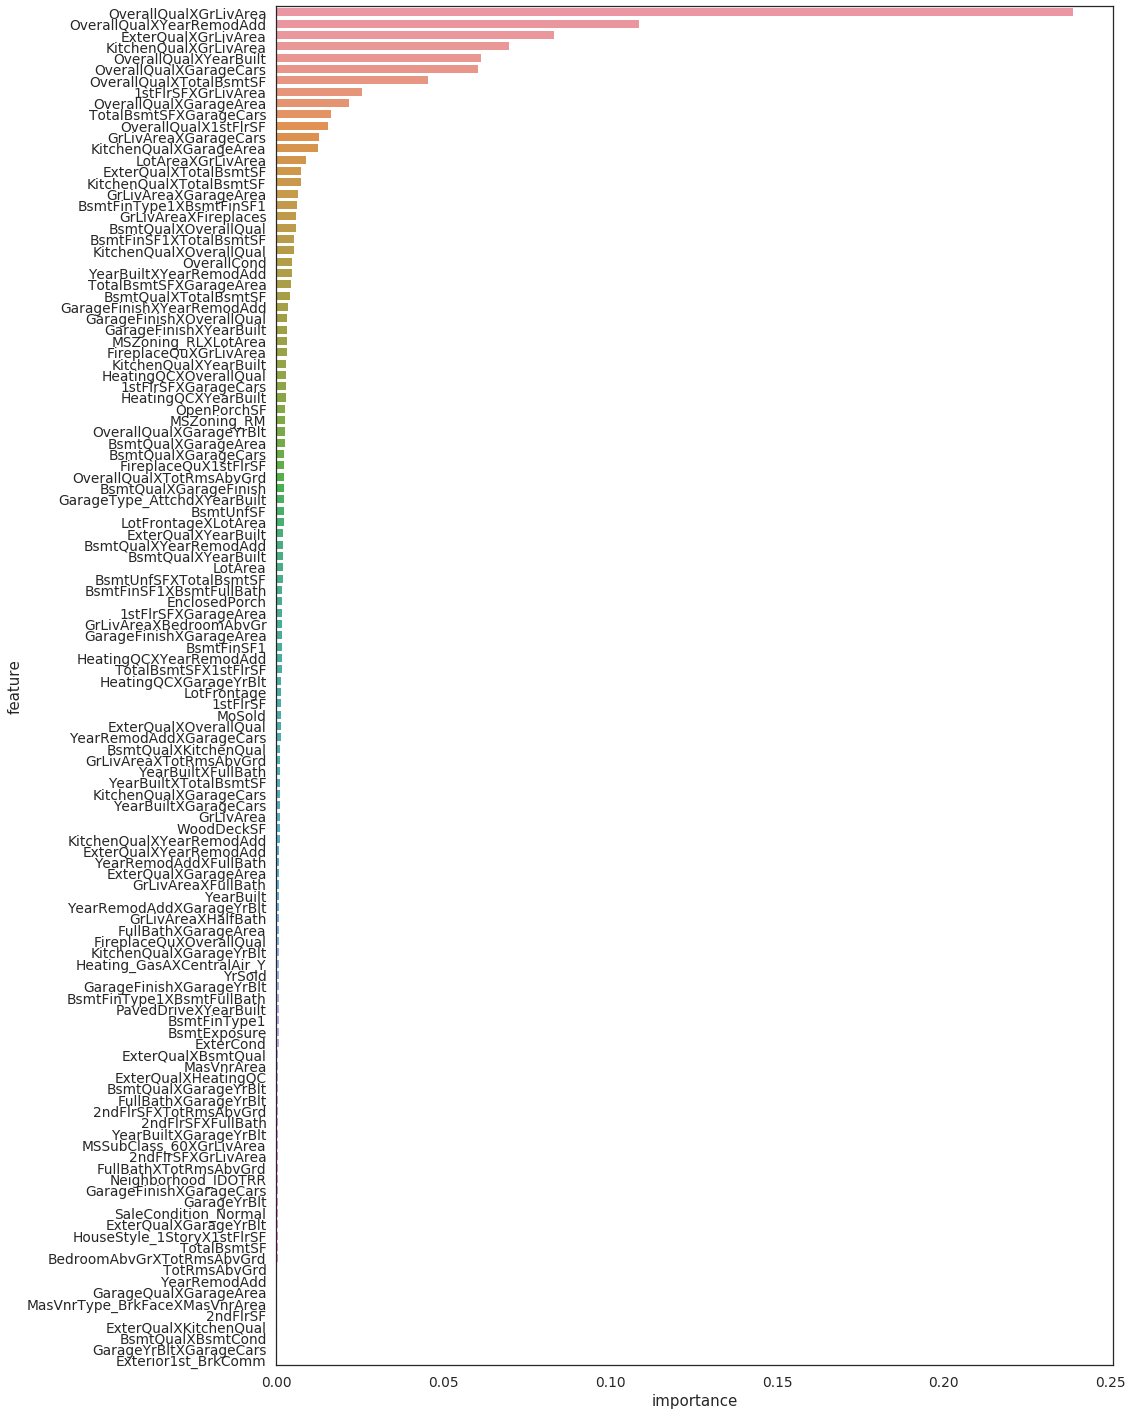

In [36]:
plt.figure(figsize=(15,25))
sns.barplot(y='feature',x='importance',data=feature_importance[feature_importance['importance']>0.0003],orient='h')

In [37]:
with open('rf_mod.pkl','rb') as rf_mod_file:
    rf_cv = pickle.load(rf_mod_file)

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [38]:
rf_cv.best_params_

{'max_depth': 75,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 200}

In [39]:
rf = RandomForestRegressor(n_estimators=200,
                           max_depth=75,
                           min_samples_leaf=3,
                           min_samples_split=4)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8954966091848396
MSE: 0.018113420754591467
RMSE: 0.1345861090699611
--------------------------------------------------
R-sq: 0.8995020220658171
MSE: 688953952.202713
RMSE: 26247.932341476215


In [40]:
feature_importance = pd.DataFrame(np.round(rf.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace =True)

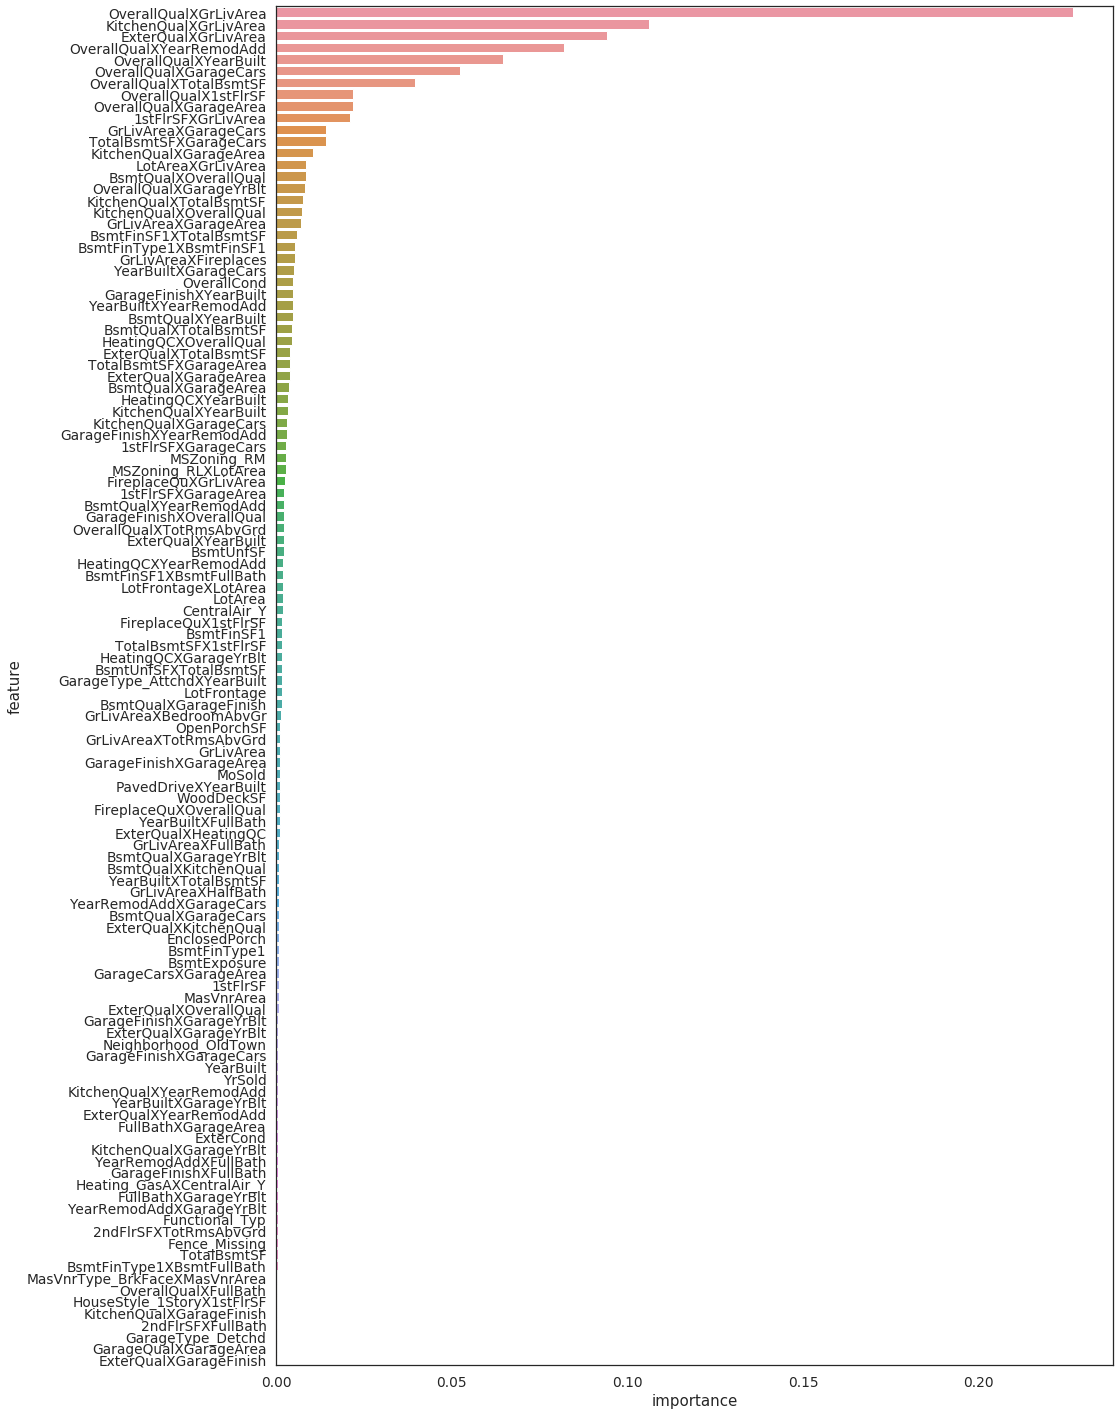

In [41]:
plt.figure(figsize=(15,25))
sns.barplot(y='feature',x='importance',data=feature_importance[feature_importance['importance']>0.0003],orient='h')

In [42]:
cv5_accuracy_train = cv_rmse(rf, X_train, y_train, cv=5)
cv5_accuracy_test = cv_rmse(rf, X_test, y_test, cv=5)

print('CV5 train R-sq:',cv5_accuracy_train)
print('-'*75)
print('CV5 test R-sq:', cv5_accuracy_test)

model_list.append(models(name='rf',params=rf.get_params(),
                         cv5_mean_accuracy_train = np.mean(cv5_accuracy_train),
                         cv5_std_accuracy_train=np.std(cv5_accuracy_train),
                         cv5_mean_accuracy_test=np.mean(cv5_accuracy_test),
                         cv5_std_accuracy_test=np.std(cv5_accuracy_test)))

CV5 train R-sq: [0.13003421 0.12725131 0.12362051 0.14836985 0.12626974]
---------------------------------------------------------------------------
CV5 test R-sq: [0.11086914 0.16966617 0.11858067 0.14947753 0.12610274]


# **AdaBoost Regression**

In [43]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [44]:
ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=75,
                                                             min_samples_leaf=3,
                                                             min_samples_split= 4),
                       n_estimators=200,learning_rate=0.5,random_state=42)

ada.fit(X_train,y_train)

y_pred = ada.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8970432896702627
MSE: 0.01784533687533308
RMSE: 0.13358643971351689
--------------------------------------------------
R-sq: 0.9067757635399116
MSE: 639089536.6304895
RMSE: 25280.2202646751


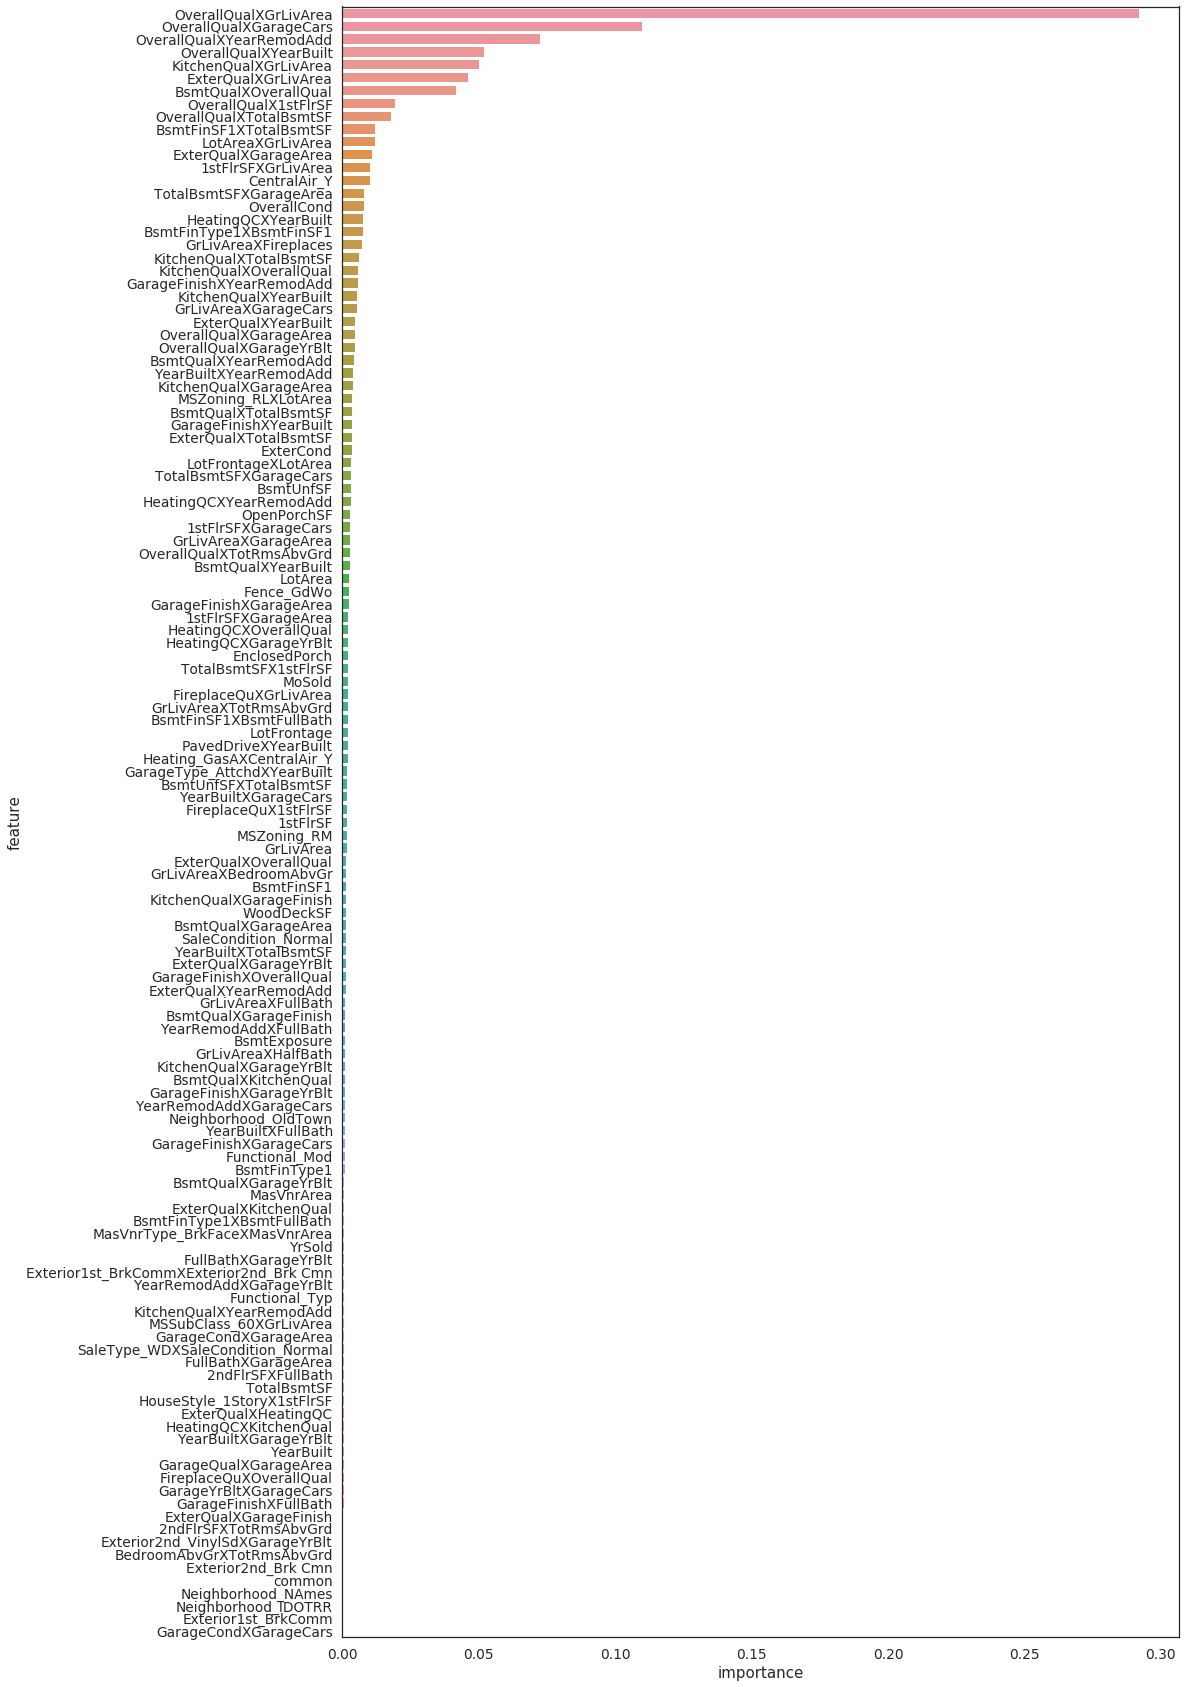

In [45]:
feature_importance = pd.DataFrame(np.round(ada.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace = True)

plt.figure(figsize=(15,30))
sns.barplot(y='feature',x='importance',data=feature_importance[feature_importance['importance']>0.0003],orient='h')

In [45]:
%%writefile AdaBoost_cv.py
#!/usr/bin/env python
#SBATCH -t 5-30:30:30
#SBATCH --cores-per-socket=4
#SBATCH --sockets-per-node=2
#SBATCH --nodes=2-4
#SBATCH --mem=24000
#SBATCH -J python
#SBATCH -o adaBoost.out


import pandas as pd
import numpy as np
import pickle

with open('processed_data.pkl','rb') as file:
    FEATURES, ordinal_map, interactions, train, y = pickle.load(file)


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=42)

print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

param_grid_tree = {
    'max_depth':[None,2,5,10,15,20,25,50,75,100],
    'min_samples_split':[2,4,8,10,15,20,25,30],
    'min_samples_leaf':[2,4,6,8,10,12,15,30],
}
tree = DecisionTreeRegressor()
tree_cv = GridSearchCV(tree,param_grid=param_grid_tree,n_jobs=-1,cv=10)
tree_cv.fit(X_train,y_train)

base_estimator = tree_cv.best_estimator_

param_grid_ada = {
    'n_estimators':[50,100,150,200,250,300,350,400],
    'learning_rate' : [0.01, 0.05, 0.1, 0.5],
    'loss' : ['linear', 'square', 'exponential'],
}

ada = AdaBoostRegressor(base_estimator=base_estimator)
ada_cv = GridSearchCV(ada,param_grid=param_grid_ada,cv=10,n_jobs=-1)
ada_cv.fit(X_train,y_train)

with open('ada_mod.pkl','wb') as out:
    pickle.dump(ada_cv,out)

Overwriting AdaBoost_cv.py


In [46]:
with open('ada_mod.pkl','rb') as mod_file:
    ada_cv = pickle.load(mod_file)

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator AdaBoostRegressor from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [47]:
ada_cv.best_params_

{'learning_rate': 0.5, 'loss': 'square', 'n_estimators': 400}

In [48]:
ada = ada_cv.best_estimator_
ada.fit(X_train,y_train)

y_pred = ada.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8958822991007784
MSE: 0.018046569682356312
RMSE: 0.13433752149848646
--------------------------------------------------
R-sq: 0.9038132755150929
MSE: 659398580.4043725
RMSE: 25678.757376562684


In [49]:
cv5_accuracy_train =  cv_rmse(ada, X_train, y_train, cv=5)
cv5_accuracy_test =  cv_rmse(ada, X_test, y_test, cv=5)

print('CV5 train R-sq:',cv5_accuracy_train)
print('-'*75)
print('CV5 test R-sq:', cv5_accuracy_test)

model_list.append(models(name='ada',params=ada.get_params(),
                         cv5_mean_accuracy_train = np.mean(cv5_accuracy_train),
                         cv5_std_accuracy_train=np.std(cv5_accuracy_train),
                         cv5_mean_accuracy_test=np.mean(cv5_accuracy_test),
                         cv5_std_accuracy_test=np.std(cv5_accuracy_test)))

CV5 train R-sq: [0.12502275 0.12794053 0.12214864 0.14606345 0.12584769]
---------------------------------------------------------------------------
CV5 test R-sq: [0.12574531 0.1563716  0.11554502 0.15696782 0.13400825]


# **Gradient Boost**

In [50]:
mod_table = pd.DataFrame()
for model in model_list:
    tmp_df = pd.DataFrame([model.name,
                           model.cv5_mean_accuracy_train,
                           model.cv5_std_accuracy_train,
                           model.cv5_mean_accuracy_test,
                           model.cv5_std_accuracy_test],
                          index=['model',
                                   'train_mean_ac',
                                   'train_std_ac',
                                   'test_mean_ac',
                                   'test_std_ac']).T
    
    mod_table = pd.concat([mod_table,tmp_df],axis=0)
    
mod_table.reset_index(drop=True,inplace=True)

In [51]:
for col in mod_table.columns:
    if col != 'model':
        mod_table[col]= mod_table[col].astype(float)

In [52]:
mod_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 5 columns):
model            7 non-null object
train_mean_ac    7 non-null float64
train_std_ac     7 non-null float64
test_mean_ac     7 non-null float64
test_std_ac      7 non-null float64
dtypes: float64(4), object(1)
memory usage: 360.0+ bytes


Text(0.5, 1.0, 'Train vs. Test R-sq')

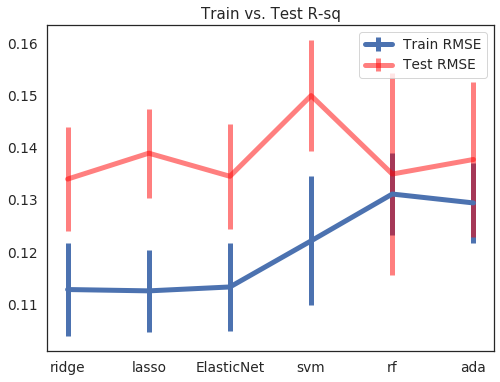

In [53]:
train_errorbar_width_array = (mod_table.loc[1:,'train_std_ac']/np.sqrt(5))*2

plt.figure(figsize =(8,6))
plt.errorbar(x=mod_table.loc[1:,'model'],
             y=mod_table.loc[1:,'train_mean_ac'],
             yerr=train_errorbar_width_array,
             label='Train RMSE',
             linewidth=5)

test_errorbar_width_array = (mod_table.loc[1:,'test_std_ac']/np.sqrt(5))*2
plt.errorbar(x=mod_table.loc[1:,'model'],
             y=mod_table.loc[1:,'test_mean_ac'],
             yerr=test_errorbar_width_array,
             label='Test RMSE',
             linewidth=5,
             color='red',
             alpha =0.5)
plt.legend()
plt.title('Train vs. Test R-sq')

In [55]:
mod_table.sort_values(by=['test_mean_ac','test_std_ac'],ascending=[True,True])

,model,train_mean_ac,train_std_ac,test_mean_ac,test_std_ac
1,ridge,0.112822,0.010051,0.133974,0.011202
3,ElasticNet,0.113313,0.009338,0.134505,0.011230
5,rf,0.131109,0.008871,0.134939,0.021644
6,ada,0.129405,0.008534,0.137728,0.016536
2,lasso,0.112567,0.008825,0.138934,0.009528
4,svm,0.122141,0.013801,0.149961,0.011909
0,LR,5.116742,6.296399,7.670471,11.532749
